In [ ]:
!pip install pandas transformers guidance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.6 MB/s eta 0:00:00


In [38]:
!pip install numpy

In [37]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch
import numpy as np
from guidance import gen
import os

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [39]:
from guidance import models
falcon = models.Transformers("tiiuae/falcon-7b-instruct",echo=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import json

# Load the dataset
with open('/content/drive/MyDrive/Master Project-Hallucination/dataset/Paraphrasing/SHROOM_trial-v1.1/trial-v1.json', 'r') as f:
    data = json.load(f)

In [42]:
import pandas as pd
# Convert the data to a DataFrame
df = pd.DataFrame(data)

### Add "binary_label"
"Not Hallucination" = 0 and "Hallucination" = 1

In [43]:
for item in data:
    if item['label'] == 'Hallucination':
        item['binary_label'] = 1
    else:
        item['binary_label'] = 0

In [44]:
def predict_hallucination(data, source, hypothesis):
    # Generate the prompt
    prompt = "Given a Text and one hypothesis determine if the hypothesis is 'Hallucination' (1) or 'Not Hallucination' (0). Here are some examples:"
    prompt_initial_length= len(prompt)
    for i in range(4):
      prompt += f'\nExample {i+1}:\nText: {data[i]["src"]}\nHypothesis: {data[i]["hyp"]}\nLabel: {data[i]["binary_label"]}'
    prompt_length_text = len(prompt)
    prompt += "\nText: " + source + "\nHypothesis: "+ hypothesis + "\nLabel:"

    # define generated output as 'gen_number'
    prediction = falcon + prompt + gen('gen_number', regex='[0-1]+', max_tokens=1, stop=',')
    # Return 'Hallucination' if the prediction is 1, 'Not Hallucination' otherwise
    print(prediction['gen_number'])
    return prediction['gen_number'], prompt, prompt_initial_length


In [45]:
# Create a new column 'prediction' and initialize it with NaN
df['prediction'] = np.nan

# Loop over the DataFrame
for i, row in df.iterrows():
    # Apply the function and store the result in the 'prediction' column
    prediction, prompt, prompt_initial_length = predict_hallucination(data, row['src'], row['hyp'])
    df.at[i, 'prediction'] = prediction

1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1


In [46]:
df_result = df

In [47]:
df_result

,hyp,ref,src,tgt,model,task,labels,label,p(Hallucination),prediction
0,"A district of Kowloon, China.",tgt,The City <define> Chiuchow </define> is Kowloo...,The Chaoshan region where the Teochew dialect ...,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
1,(Wicca) A witchdoctor.,tgt,"“ I went to see the witchdoctor , the <define>...",(South Africa) A traditional tribal diviner or...,,DM,"[Hallucination, Hallucination, Not Hallucination]",Hallucination,0.666667,1
2,(nautical) A halyard.,tgt,"Haul away , keeping strain on both parts of th...",(nautical) A staff that carries a flag or penn...,,DM,"[Hallucination, Not Hallucination, Not Halluci...",Not Hallucination,0.333333,1
3,The quality of being rational.,tgt,And what difference is there between the credi...,(archaic) The quality or state of being rational.,,DM,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
4,(uncountable) The study of trees.,tgt,It is now generally supposed that the forbidde...,The worship of trees.,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
75,I can't do it alone.,either,Je ne peux le faire seule. Il vous faut m'aider.,I can't do it alone. You have to help me.,,MT,"[Not Hallucination, Not Hallucination, Halluci...",Not Hallucination,0.333333,1
76,He lost what he received from his father.,either,Il a perdu ce qu'il a reçu de son père.,He wasted that which he had received from his ...,,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
77,We've discovered a lot of news.,either,Nous avons découvert une grande nouveauté.,We have discovered a great novelty.,,MT,"[Hallucination, Not Hallucination, Hallucination]",Hallucination,0.666667,1
78,Why is everyone okay?,either,Pourquoi est-ce que tout le monde rigole ?,Why is everyone laughing?,,MT,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1


# Evaluation

In [48]:
def save_confusion_matrix(data, index, df_result):
  label_true = [item['binary_label'] for item in data[4:] if 'binary_label' in item]
  label_pred = list(map(int, df_result["prediction"][4:].tolist()))

  conf_matrix = confusion_matrix(label_true, label_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
  fig, ax = plt.subplots()
  cm_display.plot(ax=ax)
  plt.savefig(f'/content/drive/MyDrive/Master Project-Hallucination/Group1_results/falcon2/{index}_confusion_matrix.png')
  plt.show()


In [49]:
def calculate_evaluation(data, df_result):
  label_true = [item['binary_label'] for item in data[4:] if 'binary_label' in item]
  label_pred = list(map(int, df_result["prediction"][4:].tolist()))
  accuracy = accuracy_score(label_true, label_pred)
  f1 =f1_score(label_true, label_pred)
  return accuracy, f1


In [50]:
import os
def save_results(accuracy, f1, data, df_result):
  if os.path.isfile('/content/drive/MyDrive/Master Project-Hallucination/Group1_results/falcon2/results.csv'):
    df = pd.read_csv('/content/drive/MyDrive/Master Project-Hallucination/Group1_results/falcon2/results.csv')
    new_row = {'prompt': prompt[:prompt_initial_length], 'accuracy': accuracy, 'f1 score': f1}
    # Append the dictionary to the DataFrame
    df.loc[len(df)] = new_row
    index = len(df) - 1
    print(index)
    save_confusion_matrix(data, index, df_result)
    df.to_csv('/content/drive/MyDrive/Master Project-Hallucination/Group1_results/falcon2/results.csv', index=False)

  else:
    d = {'prompt': [prompt[:prompt_initial_length]], 'accuracy': [accuracy], 'f1 score': [f1]}
    df = pd.DataFrame(data=d)
    df.to_csv('/content/drive/MyDrive/Master Project-Hallucination/Group1_results/falcon2/results.csv')
    index = 0
    save_confusion_matrix(data, index, df_result)


In [ ]:
len(df)

80

In [51]:
accuracy, f1 = calculate_evaluation(data,df_result)

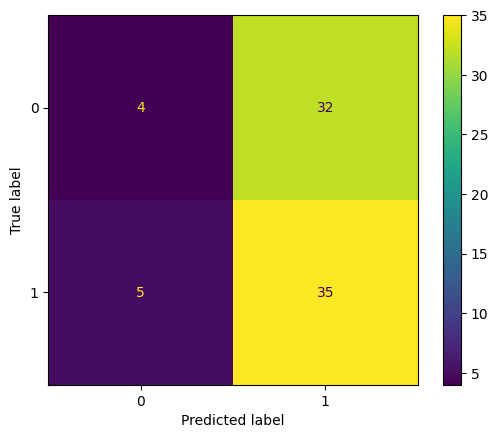

In [52]:
save_results(accuracy, f1, data, df_result)

# Try different types of prompts

## Give Definition of Hallucination


In [53]:
def predict_hallucination(data, source, hypothesis):
    # Generate the prompt
    prompt = "Given a Text and one hypothesis determine if the hypothesis is 'Hallucination' (1) or 'Not Hallucination' (0). Hallucinations can contradict the source material directly and offer logical inconsistency and factual inaccuracies. Another type of Hallucination does not contradict. However, at the same time, it cannot be verified against any source. Hence, it adds elements that are considered to be unconfirmable and speculative. Answer only with 1 or 0. Here are some examples:"
    prompt_initial_length= len(prompt)
    for i in range(4):
      prompt += f'\nExample {i+1}:\nText: {data[i]["src"]}\nHypothesis: {data[i]["hyp"]}\nLabel: {data[i]["binary_label"]}'
    prompt_length_text = len(prompt)
    prompt += "\nText: " + source + "\nHypothesis: "+ hypothesis + "\nLabel:"

    # define generated output as 'gen_number'
    prediction = falcon + prompt + gen('gen_number', regex='[0-1]+', max_tokens=1, stop=',')
    # Return 'Hallucination' if the prediction is 1, 'Not Hallucination' otherwise
    #print(prediction['gen_number'])
    return prediction['gen_number'], prompt, prompt_initial_length

In [54]:
df

,hyp,ref,src,tgt,model,task,labels,label,p(Hallucination),prediction
0,"A district of Kowloon, China.",tgt,The City <define> Chiuchow </define> is Kowloo...,The Chaoshan region where the Teochew dialect ...,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
1,(Wicca) A witchdoctor.,tgt,"“ I went to see the witchdoctor , the <define>...",(South Africa) A traditional tribal diviner or...,,DM,"[Hallucination, Hallucination, Not Hallucination]",Hallucination,0.666667,1
2,(nautical) A halyard.,tgt,"Haul away , keeping strain on both parts of th...",(nautical) A staff that carries a flag or penn...,,DM,"[Hallucination, Not Hallucination, Not Halluci...",Not Hallucination,0.333333,1
3,The quality of being rational.,tgt,And what difference is there between the credi...,(archaic) The quality or state of being rational.,,DM,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
4,(uncountable) The study of trees.,tgt,It is now generally supposed that the forbidde...,The worship of trees.,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
75,I can't do it alone.,either,Je ne peux le faire seule. Il vous faut m'aider.,I can't do it alone. You have to help me.,,MT,"[Not Hallucination, Not Hallucination, Halluci...",Not Hallucination,0.333333,1
76,He lost what he received from his father.,either,Il a perdu ce qu'il a reçu de son père.,He wasted that which he had received from his ...,,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
77,We've discovered a lot of news.,either,Nous avons découvert une grande nouveauté.,We have discovered a great novelty.,,MT,"[Hallucination, Not Hallucination, Hallucination]",Hallucination,0.666667,1
78,Why is everyone okay?,either,Pourquoi est-ce que tout le monde rigole ?,Why is everyone laughing?,,MT,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1


In [55]:
df['prediction'] = np.nan


In [56]:
df

,hyp,ref,src,tgt,model,task,labels,label,p(Hallucination),prediction
0,"A district of Kowloon, China.",tgt,The City <define> Chiuchow </define> is Kowloo...,The Chaoshan region where the Teochew dialect ...,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,NaN
1,(Wicca) A witchdoctor.,tgt,"“ I went to see the witchdoctor , the <define>...",(South Africa) A traditional tribal diviner or...,,DM,"[Hallucination, Hallucination, Not Hallucination]",Hallucination,0.666667,NaN
2,(nautical) A halyard.,tgt,"Haul away , keeping strain on both parts of th...",(nautical) A staff that carries a flag or penn...,,DM,"[Hallucination, Not Hallucination, Not Halluci...",Not Hallucination,0.333333,NaN
3,The quality of being rational.,tgt,And what difference is there between the credi...,(archaic) The quality or state of being rational.,,DM,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,NaN
4,(uncountable) The study of trees.,tgt,It is now generally supposed that the forbidde...,The worship of trees.,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
75,I can't do it alone.,either,Je ne peux le faire seule. Il vous faut m'aider.,I can't do it alone. You have to help me.,,MT,"[Not Hallucination, Not Hallucination, Halluci...",Not Hallucination,0.333333,NaN
76,He lost what he received from his father.,either,Il a perdu ce qu'il a reçu de son père.,He wasted that which he had received from his ...,,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,NaN
77,We've discovered a lot of news.,either,Nous avons découvert une grande nouveauté.,We have discovered a great novelty.,,MT,"[Hallucination, Not Hallucination, Hallucination]",Hallucination,0.666667,NaN
78,Why is everyone okay?,either,Pourquoi est-ce que tout le monde rigole ?,Why is everyone laughing?,,MT,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,NaN


In [57]:


# Loop over the DataFrame
for i, row in df.iterrows():
    # Apply the function and store the result in the 'prediction' column
    prediction, prompt, prompt_initial_length = predict_hallucination(data, row['src'], row['hyp'])
    df.at[i, 'prediction'] = prediction

In [59]:
df_result = df

In [60]:
df_result

,hyp,ref,src,tgt,model,task,labels,label,p(Hallucination),prediction
0,"A district of Kowloon, China.",tgt,The City <define> Chiuchow </define> is Kowloo...,The Chaoshan region where the Teochew dialect ...,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
1,(Wicca) A witchdoctor.,tgt,"“ I went to see the witchdoctor , the <define>...",(South Africa) A traditional tribal diviner or...,,DM,"[Hallucination, Hallucination, Not Hallucination]",Hallucination,0.666667,1
2,(nautical) A halyard.,tgt,"Haul away , keeping strain on both parts of th...",(nautical) A staff that carries a flag or penn...,,DM,"[Hallucination, Not Hallucination, Not Halluci...",Not Hallucination,0.333333,1
3,The quality of being rational.,tgt,And what difference is there between the credi...,(archaic) The quality or state of being rational.,,DM,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
4,(uncountable) The study of trees.,tgt,It is now generally supposed that the forbidde...,The worship of trees.,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
75,I can't do it alone.,either,Je ne peux le faire seule. Il vous faut m'aider.,I can't do it alone. You have to help me.,,MT,"[Not Hallucination, Not Hallucination, Halluci...",Not Hallucination,0.333333,1
76,He lost what he received from his father.,either,Il a perdu ce qu'il a reçu de son père.,He wasted that which he had received from his ...,,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
77,We've discovered a lot of news.,either,Nous avons découvert une grande nouveauté.,We have discovered a great novelty.,,MT,"[Hallucination, Not Hallucination, Hallucination]",Hallucination,0.666667,1
78,Why is everyone okay?,either,Pourquoi est-ce que tout le monde rigole ?,Why is everyone laughing?,,MT,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1


In [61]:
accuracy, f1 = calculate_evaluation(data, df_result)

1


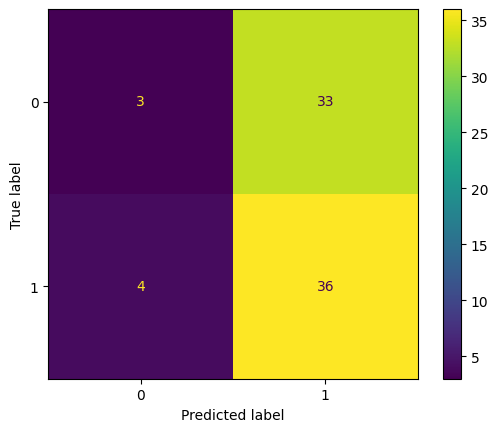

In [62]:
save_results(accuracy, f1, data, df_result)

In [64]:
f1

0.6605504587155964

## Explain Hallucination and give reasoning why examples are hallucinated and why not

In [67]:
def predict_hallucination(data, source, hypothesis):
    # Generate the prompt
    prompt = "Given a Text and one hypothesis determine if the hypothesis is 'Hallucination' (1) or 'Not Hallucination' (0). Hallucinations can contradict the source material directly and offer logical inconsistency and factual inaccuracies. Another type of Hallucination does not contradict. However, at the same time, it cannot be verified against any source. Hence, it adds elements that are considered to be unconfirmable and speculative. Please answer only with 1 or 0. Here are some examples:"
    prompt_inital_length= len(prompt)
    prompt += f'\nExample {0}:\nText: {data[0]["src"]}\nHypothesis: {data[0]["hyp"]}\nLabel: {data[0]["binary_label"]}'
    prompt += "\nThe hypothesis 'A district of Kowloon, China' is considered a hallucination in this context because it misinterprets the information in the source text. The text mentions a restaurant called The City Chiuchow, which is famous for its goose dishes and specialities from the Chiuchow region. However, there is no indication in the text that Kowloon refers to a district. Kowloon is actually a district within Hong Kong, not a separate district within China. Therefore, the assumption that Kowloon is a district is a misinterpretation or hallucination, as it deviates from the reality presented in the text."
    prompt += f'\nExample {1}:\nText: {data[1]["src"]}\nHypothesis: {data[1]["hyp"]}\nLabel: {data[1]["binary_label"]}'
    prompt += "\nThe hypothesis '(Wicca) A witchdoctor' is considered a hallucination in this context because it inaccurately interprets the information provided in the source text. The source text mentions visiting a witchdoctor, referred to as 'igqira,' who communicates with the spirits of the ancestors, known as izinyanya. The term witchdoctor typically refers to a traditional healer or spiritual practitioner in various cultures, especially in African or indigenous communities, and is not specific to Wicca. Therefore, assuming that the witchdoctor mentioned in the text is associated with Wicca is a misinterpretation or hallucination, as it deviates from the cultural and contextual information provided."
    prompt += f'\nExample {2}:\nText: {data[2]["src"]}\nHypothesis: {data[2]["hyp"]}\nLabel: {data[2]["binary_label"]}'
    prompt += "\nThe hypothesis '(nautical) A halyard' is considered not hallucination in this context because it accurately interprets the terminology used in the source text. The text mentions 'halyard' implicitly by describing the action of 'keeping strain on both parts of the halyard' to ensure that the 'pigstick' remains vertical. A halyard is a rope or tackle used for hoisting and lowering sails, flags, or other objects on a ship. Since the term 'halyard' is directly related to nautical terminology and fits the context of the action described in the text, the hypothesis aligns with the information provided and is therefore considered accurate rather than a hallucination."
    prompt += f'\nExample {3}:\nText: {data[3]["src"]}\nHypothesis: {data[3]["hyp"]}\nLabel: {data[3]["binary_label"]}'
    prompt += "\nThe hypothesis 'The quality of being rational' is not deemed a hallucination in this context because it aligns with the content of the source text."

    prompt_length_text = len(prompt)
    prompt += "\nText: " + source + "\nHypothesis: "+ hypothesis + "\nLabel:"

    # define generated output as 'gen_number'
    prediction = falcon + prompt + gen('gen_number', regex='[0-1]+', max_tokens=1, stop=',')
    # Return 'Hallucination' if the prediction is 1, 'Not Hallucination' otherwise
    #print(prediction['gen_number'])
    return prediction['gen_number'], prompt, prompt_initial_length

In [68]:
# Create a new column 'prediction' and initialize it with NaN
df['prediction'] = np.nan

# Loop over the DataFrame
for i, row in df.iterrows():
    # Apply the function and store the result in the 'prediction' column
    prediction, prompt, prompt_initial_length = predict_hallucination(data, row['src'], row['hyp'])
    print(prompt)
    df.at[i, 'prediction'] = prediction

Given a Text and one hypothesis determine if the hypothesis is 'Hallucination' (1) or 'Not Hallucination' (0). Hallucinations can contradict the source material directly and offer logical inconsistency and factual inaccuracies. Another type of Hallucination does not contradict. However, at the same time, it cannot be verified against any source. Hence, it adds elements that are considered to be unconfirmable and speculative. Please answer only with 1 or 0. Here are some examples:
Example 0:
Text: The City <define> Chiuchow </define> is Kowloon 's other top restaurant and is famous for its goose dishes and other specialties from the Chiuchow region ( you may also wish to try the beef satay done in a creamy sauce ) .
Hypothesis: A district of Kowloon, China.
Label: 1
The hypothesis 'A district of Kowloon, China' is considered a hallucination in this context because it misinterprets the information in the source text. The text mentions a restaurant called The City Chiuchow, which is famou

In [70]:
df_result = df

In [71]:
df_result

,hyp,ref,src,tgt,model,task,labels,label,p(Hallucination),prediction
0,"A district of Kowloon, China.",tgt,The City <define> Chiuchow </define> is Kowloo...,The Chaoshan region where the Teochew dialect ...,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
1,(Wicca) A witchdoctor.,tgt,"“ I went to see the witchdoctor , the <define>...",(South Africa) A traditional tribal diviner or...,,DM,"[Hallucination, Hallucination, Not Hallucination]",Hallucination,0.666667,1
2,(nautical) A halyard.,tgt,"Haul away , keeping strain on both parts of th...",(nautical) A staff that carries a flag or penn...,,DM,"[Hallucination, Not Hallucination, Not Halluci...",Not Hallucination,0.333333,1
3,The quality of being rational.,tgt,And what difference is there between the credi...,(archaic) The quality or state of being rational.,,DM,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
4,(uncountable) The study of trees.,tgt,It is now generally supposed that the forbidde...,The worship of trees.,,DM,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
75,I can't do it alone.,either,Je ne peux le faire seule. Il vous faut m'aider.,I can't do it alone. You have to help me.,,MT,"[Not Hallucination, Not Hallucination, Halluci...",Not Hallucination,0.333333,1
76,He lost what he received from his father.,either,Il a perdu ce qu'il a reçu de son père.,He wasted that which he had received from his ...,,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.000000,1
77,We've discovered a lot of news.,either,Nous avons découvert une grande nouveauté.,We have discovered a great novelty.,,MT,"[Hallucination, Not Hallucination, Hallucination]",Hallucination,0.666667,1
78,Why is everyone okay?,either,Pourquoi est-ce que tout le monde rigole ?,Why is everyone laughing?,,MT,"[Hallucination, Hallucination, Hallucination]",Hallucination,1.000000,1


In [73]:
accuracy, f1 = calculate_evaluation(data, df_result)

2


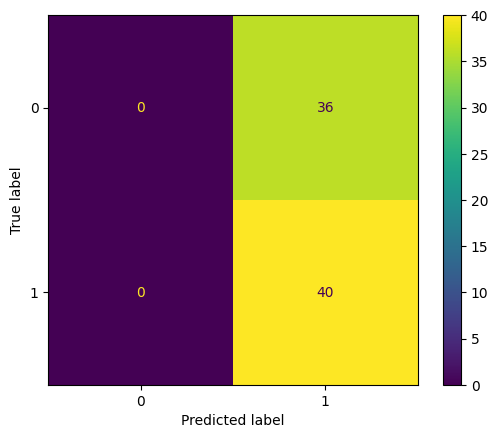

In [74]:
save_results(accuracy, f1, data,df_result)

In [76]:
f1

0.6896551724137931

## Give a role and describe the task

In [ ]:
def predict_hallucination(data, source, hypothesis):
    # Generate the prompt
    prompt = "Imagine you are a classifier. Given a Text and one hypothesis. Your task is to classify if the hypothesis is 'Hallucination' (1) or 'Not Hallucination' (0). Here are some examples:"
    prompt_initial_length= len(prompt)
    for i in range(4):
      prompt += f'\nExample {i+1}:\nText: {data[i]["src"]}\nHypothesis: {data[i]["hyp"]}\nLabel: {data[i]["binary_label"]}'
    prompt_length_text = len(prompt)
    prompt += "\nText: " + source + "\nHypothesis: "+ hypothesis + "\nLabel:"

    # define generated output as 'gen_number'
    prediction = falcon + prompt + gen('gen_number', regex='[0-1]+', max_tokens=1, stop=',')
    # Return 'Hallucination' if the prediction is 1, 'Not Hallucination' otherwise
    #print(prediction['gen_number'])
    return prediction['gen_number'], prompt, prompt_initial_length

In [ ]:
# Create a new column 'prediction' and initialize it with NaN
df['prediction'] = np.nan

# Loop over the DataFrame
for i, row in df.iterrows():
    # Apply the function and store the result in the 'prediction' column
    prediction, prompt, prompt_initial_length = predict_hallucination(data, row['src'], row['hyp'])
    df.at[i, 'prediction'] = prediction

In [ ]:
df_result = df

In [ ]:
accuracy, f1 = calculate_evaluation(data)

3


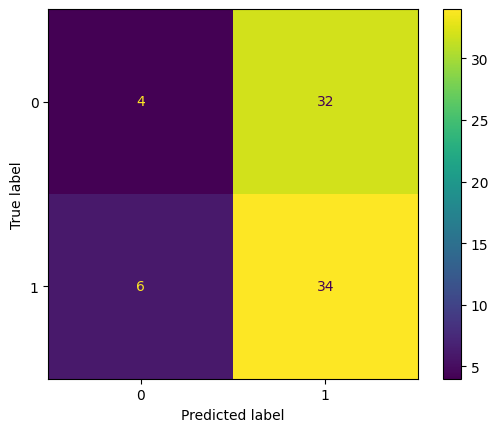

In [ ]:
save_results(accuracy, f1, data)

### Chain of Thought and reasoning steps

In [ ]:
def predict_hallucination(data, source, hypothesis):
    # Generate the prompt
    prompt = "Imagine you are a classifier. Given a Text and one hypothesis. Your task is to classify if the hypothesis is 'Hallucination' (1) or 'Not Hallucination' (0). Explain your choice. Here are some examples:"
    prompt_inital_length= len(prompt)
    prompt += f'\nExample {0}:\nText: {data[0]["src"]}\nHypothesis: {data[0]["hyp"]}\nLabel: {data[0]["binary_label"]}'
    prompt += "The hypothesis 'A district of Kowloon, China' is considered a hallucination in this context because it misinterprets the information in the source text. The text mentions a restaurant called The City Chiuchow, which is famous for its goose dishes and specialities from the Chiuchow region. However, there is no indication in the text that Kowloon refers to a district. Kowloon is actually a district within Hong Kong, not a separate district within China. Therefore, the assumption that Kowloon is a district is a misinterpretation or hallucination, as it deviates from the reality presented in the text."
    prompt += f'\nExample {1}:\nText: {data[1]["src"]}\nHypothesis: {data[1]["hyp"]}\nLabel: {data[1]["binary_label"]}'
    prompt += "The hypothesis '(Wicca) A witchdoctor' is considered a hallucination in this context because it inaccurately interprets the information provided in the source text. The source text mentions visiting a witchdoctor, referred to as 'igqira,' who communicates with the spirits of the ancestors, known as izinyanya. The term witchdoctor typically refers to a traditional healer or spiritual practitioner in various cultures, especially in African or indigenous communities, and is not specific to Wicca. Therefore, assuming that the witchdoctor mentioned in the text is associated with Wicca is a misinterpretation or hallucination, as it deviates from the cultural and contextual information provided."
    prompt += f'\nExample {2}:\nText: {data[2]["src"]}\nHypothesis: {data[2]["hyp"]}\nLabel: {data[2]["binary_label"]}'
    prompt += "The hypothesis '(nautical) A halyard' is considered not hallucination in this context because it accurately interprets the terminology used in the source text. The text mentions 'halyard' implicitly by describing the action of 'keeping strain on both parts of the halyard' to ensure that the 'pigstick' remains vertical. A halyard is a rope or tackle used for hoisting and lowering sails, flags, or other objects on a ship. Since the term 'halyard' is directly related to nautical terminology and fits the context of the action described in the text, the hypothesis aligns with the information provided and is therefore considered accurate rather than a hallucination."
    prompt += f'\nExample {3}:\nText: {data[3]["src"]}\nHypothesis: {data[3]["hyp"]}\nLabel: {data[3]["binary_label"]}'
    prompt += "The hypothesis 'The quality of being rational' is not deemed a hallucination in this context because it aligns with the content of the source text."
    prompt_length_text = len(prompt)
    prompt += "\nText: " + source + "\nHypothesis: "+ hypothesis + "\nLabel:"

    # define generated output as 'gen_number'
    prediction = falcon + prompt + gen('gen_number', regex='[0-1]+', max_tokens=1, stop=',')
    # Return 'Hallucination' if the prediction is 1, 'Not Hallucination' otherwise
    #print(prediction['gen_number'])
    return prediction['gen_number'], prompt, prompt_initial_length

In [ ]:
# Create a new column 'prediction' and initialize it with NaN
df['prediction'] = np.nan

# Loop over the DataFrame
for i, row in df.iterrows():
    # Apply the function and store the result in the 'prediction' column
    prediction, prompt, prompt_initial_length = predict_hallucination(data, row['src'], row['hyp'])
    df.at[i, 'prediction'] = prediction

In [ ]:
df_result = df

In [ ]:
accuracy, f1 = calculate_evaluation(data)

4


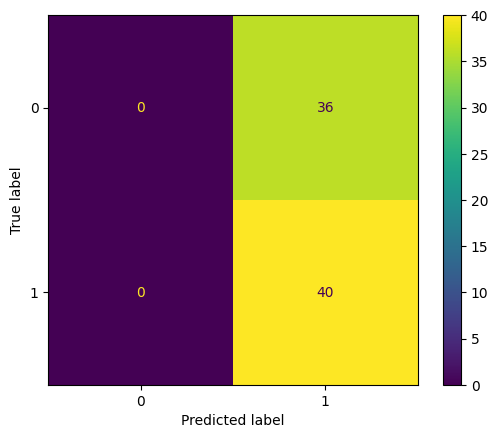

In [ ]:
save_results(accuracy, f1, data)